<a href="https://colab.research.google.com/github/katrin-ibrahim/Urban-Sound-Tagging-using-EfficientNet/blob/main/ESC50_ESC10_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi

Mon Jun  6 11:21:37 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 13.6 gigabytes of available RAM

Not using a high-RAM runtime


#Download Dataset

In [1]:
# Mounting google drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
base_dir = "/content/drive/MyDrive"
meta_dir = base_dir + '/ESC-50/ESC-50-master/meta'
audio_dir = base_dir + '/ESC-50/ESC-50-master/audio'
augmented_audio_dir = '/content/augmented_audio'
log_dir = base_dir + "/ESC-50/data/logs"
embeddings_dir = base_dir +'/ESC-50/data/embeddings'
saved_models_dir = base_dir + '/ESC-50/data/saved_models'

In [3]:
!mkdir /content/augmented_audio

In [ ]:
# Only run first time
# !mkdir  /content/drive/MyDrive/ESC-50/data
# !mkdir /content/drive/MyDrive/ESC-50/data/saved_models
# !mkdir /content/drive/MyDrive/ESC-50/data/logs
# !mkdir /content/drive/MyDrive/ESC-50/data/embeddings

mkdir: cannot create directory ‘/content/drive/MyDrive/ESC-50/data’: File exists
mkdir: cannot create directory ‘/content/drive/MyDrive/ESC-50/data/saved_models’: File exists
mkdir: cannot create directory ‘/content/drive/MyDrive/ESC-50/data/logs’: File exists
mkdir: cannot create directory ‘/content/drive/MyDrive/ESC-50/data/embeddings’: File exists


In [ ]:
# Only run first time to download dataset
#!wget https://github.com/karolpiczak/ESC-50/archive/master.zip
#!unzip master.zip

In [ ]:
# Only run first time to copy dataset to drive
#!cp -r ./ESC-50-master /content/drive/MyDrive/ESC-50/

#Import Libraries

In [4]:
%%capture
!pip install autopool
!pip install audiomentations

In [21]:
import os
from tqdm import tqdm

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn import metrics
from sklearn.utils import shuffle
from sklearn.metrics import classification_report, confusion_matrix


import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Dropout, Activation, GlobalAveragePooling2D, TimeDistributed, Reshape
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import EfficientNetB5
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical


import librosa, librosa.display
import IPython.display as ipd
import csv
import datetime

from autopool.keras import AutoPool1D
from scipy.io.wavfile import write
from audiomentations import Compose, AddGaussianNoise, FrequencyMask, TimeStretch, PitchShift, Shift, AddBackgroundNoise

In [ ]:
print(tf.__version__)

2.8.0


#Variables

In [6]:
metadata = pd.read_csv('/content/drive/MyDrive/ESC-50/ESC-50-master/meta/esc50.csv')
metadata.head()

,filename,fold,target,category,esc10,src_file,take
0,1-100032-A-0.wav,1,0,dog,True,100032,A
1,1-100038-A-14.wav,1,14,chirping_birds,False,100038,A
2,1-100210-A-36.wav,1,36,vacuum_cleaner,False,100210,A
3,1-100210-B-36.wav,1,36,vacuum_cleaner,False,100210,B
4,1-101296-A-19.wav,1,19,thunderstorm,False,101296,A


In [7]:
srate = 44100 ###### 22050 --> 1104   32000 --> 800   44100*2206    BEST 44100 1024
n_fft = 1024
win_len = 1024
hop_len = 512

n_mels = 128
mono = True
# resample = 'kaiser_best'
# extraction = True #False

second = 2.5

In [8]:
epochs = 25
batch_size = 32
augmentations_arr = ['ps(-1)','ps(-2)'] 

#EDA


In [ ]:
metadata['category'].value_counts()

In [ ]:
import glob 
drive_audio_path = glob.glob(base_dir + '/ESC-50/ESC-50-master/audio/*.wav', recursive=True)
print(f"Total Audio Files : {len(drive_audio_path)}")

Total Audio Files : 2000


In [9]:
def load_sample_by_index(index):
  sample_wav = metadata.filename[index]
  sample_path = base_dir + '/ESC-50/ESC-50-master/audio'
  sample_filename = os.path.join(sample_path, sample_wav) 
  y, sr = librosa.load(sample_filename,sr=srate)
  return y,sr,sample_filename


In [10]:
def plot_sample_wave(y,path):
  plt.plot(y)
  plt.title('Signal');
  plt.xlabel('Time (samples)');
  plt.ylabel('Amplitude');

In [11]:
def plot_sample_spec(y):
  mel_spect = librosa.feature.melspectrogram(y=y, sr=srate, n_fft=n_fft, hop_length=hop_len)
  mel_spect = librosa.power_to_db(mel_spect, ref=np.max)
  librosa.display.specshow(mel_spect, y_axis='mel', fmax=8000, x_axis='time');
  plt.title('Log-Mel Spectrogram');
  plt.colorbar(format='%+2.0f dB');

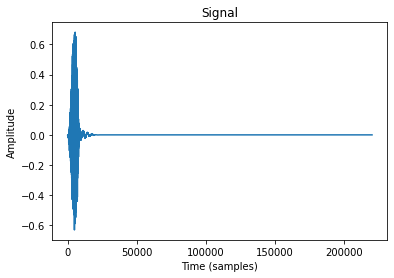

In [22]:
y,sr,path = load_sample_by_index(14)
plot_sample_wave(y,path)

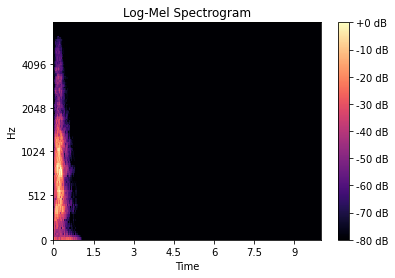

In [23]:
plot_sample_spec(y)

In [24]:
ipd.Audio(path)

#ESC-10 Metadata

In [12]:
# If using esc10 
metadata = metadata.loc[metadata.esc10 == True]
metadata

,filename,fold,target,category,esc10,src_file,take
0,1-100032-A-0.wav,1,0,dog,True,100032,A
14,1-110389-A-0.wav,1,0,dog,True,110389,A
24,1-116765-A-41.wav,1,41,chainsaw,True,116765,A
54,1-17150-A-12.wav,1,12,crackling_fire,True,17150,A
55,1-172649-A-40.wav,1,40,helicopter,True,172649,A
...,...,...,...,...,...,...,...
1876,5-233160-A-1.wav,5,1,rooster,True,233160,A
1888,5-234879-A-1.wav,5,1,rooster,True,234879,A
1889,5-234879-B-1.wav,5,1,rooster,True,234879,B
1894,5-235671-A-38.wav,5,38,clock_tick,True,235671,A


In [ ]:
metadata['category'].value_counts()

dog               40
chainsaw          40
crackling_fire    40
helicopter        40
rain              40
crying_baby       40
clock_tick        40
sneezing          40
rooster           40
sea_waves         40
Name: category, dtype: int64

#Data Augmentation
> the augmented audio will be saved to whichever directory you specify above 




In [13]:
def time_stretch(signal,sr,stretch_rate,sample_len):
  y = librosa.effects.time_stretch(signal, stretch_rate,)
  if len(y) > sample_len*sr:
    y = y[:sample_len*sr]
  elif len(y) < sample_len*sr:
    y = librosa.util.fix_length(y,sample_len*sr,mode='edge')
  return y


def pitch_shift(signal,sr,num_semitones):
  return librosa.effects.pitch_shift(signal,sr,num_semitones)

noise = Compose([
  AddGaussianNoise(min_amplitude=0.005, max_amplitude=0.15, p=1),
])
 

bg_noise = Compose([
    AddBackgroundNoise('/content/drive/MyDrive/ESC-50/data/bg_noise', 5 , 30 , 'relative' ,p=1)
])
 

In [14]:
def augmentation_helper(aug_name,y,sr):
  if aug_name == "noise":
    aug_y = noise(y,sr)

  elif aug_name == "bg":
    aug_y = bg_noise(y,sr)
    
  elif aug_name == "ps(-1)":
    aug_y = pitch_shift(y,sr,-1)

  elif aug_name == "ps(-2)":
    aug_y = pitch_shift(y,sr,-2)
  return aug_y


def apply_augmentation():
  count = 0
  for index,row in tqdm(metadata.iterrows()):
      if count%20 == 0:
        print(f"augmenting audio signal number : {count}/{len(metadata)}")
        
      
      y,sr,p = load_sample_by_index(index)
      # print(path)

      #loop over list of augmentations to apply them to all 
      for aug in augmentations_arr :
        aug_y = augmentation_helper(aug_name=aug, y=y, sr=sr)
        path = os.path.join(augmented_audio_dir,aug+"_"+ str(row["filename"]))
        print(aug,path)
        if os.path.exists(path) == False:
          write(path,sr, aug_y)
      count+=1




def get_metadata(meta_dir):
  csv_fields = ['filename', 'fold', 'target', 'category', 'src_file', 'take', 'augmented']
  count = 0
  dict_arr = []
  for index,row in tqdm(metadata.iterrows()):
    for aug in augmentations_arr :
      dict_arr.append({'filename':aug+"_"+row["filename"], 'fold':row["fold"], 'target': row["target"], 'category':row["category"], 'src_file': row["src_file"], 'take': row["take"]})
    dict_arr.append({'filename':row["filename"], 'fold':row["fold"], 'target': row["target"], 'category':row["category"], 'src_file': row["src_file"], 'take': row["take"]})


  with open(meta_dir, 'w') as csvfile:
    writer = csv.DictWriter(csvfile, fieldnames = csv_fields)
    writer.writeheader()
    writer.writerows(dict_arr)


  return (pd.read_csv(meta_dir))

In [ ]:
apply_augmentation()

##Get Augmented Metadata

In [ ]:
metadata_aug = get_metadata("aug.csv") 
len(metadata_aug)

400it [00:00, 9056.43it/s]


1200

##Visualise Augmentations

In [17]:
y,sr,filename = load_sample_by_index(14)

In [30]:
ipd.Audio(filename)

In [38]:
aug_y = augmentation_helper("ps(-2)",y,sr)
write('aug.wav',sr, aug_y)
ipd.Audio('aug.wav')

#Feature Extraction
> the following will extract feature embeddings which will be saved to whichever directory you specify above 

In [ ]:
def feature_extractor(filename, srate=srate):

    if filename[0].isdigit() == True :
        file_name = os.path.join(audio_dir, filename)
    else :
        file_name = os.path.join(augmented_audio_dir, filename) 
  
    try:
        y, sr = librosa.load(file_name, sr=srate, mono=mono)
    except:
        raise IOError('Give me an audio  file which I can read!!')

    feature_data = []

    for i in range(2):
      i = i*int(srate*second)

      if i+ int(srate*second)>srate*10:
        break
    
      split_y = y[i : i + int(srate*second)]
      inpt = librosa.power_to_db(librosa.feature.melspectrogram(y=split_y, sr=srate, n_fft=n_fft, hop_length=hop_len, win_length=win_len, n_mels=n_mels))
      
      inpt = np.array(inpt)
      stack_inpt = np.stack(([inpt], [inpt], [inpt]), axis=3)
      feature = np.reshape(stack_inpt, (stack_inpt.shape[1], stack_inpt.shape[2], stack_inpt.shape[3]))
      feature_data.append(feature)
      
    feature_data = np.asarray(feature_data)
    return feature_data

In [ ]:
for index, row in tqdm(metadata_aug.iterrows()):
  
    filename = row["filename"]
    path = os.path.join(embeddings_dir,filename+".npy")
   
    if os.path.exists(path) == False:
      feature = feature_extractor(filename)
      x = np.array(feature)
      np.save(os.path.join(embeddings_dir,filename),x)
      print(f"extraction file: {filename} in index: {index}/{len(metadata)}")
    else:
      print(f'already extracted features for sample in index: {index}')

#Data Split / Pre-proccessing


In [ ]:
def load_feature(filename):
  x = np.load(os.path.join(embeddings_dir,filename+".npy"))
  return x


def get_train_test_split(test_fold,use_augmented_data=True):
  if use_augmented_data == True :
    train_meta = metadata_aug.loc[metadata_aug.fold!=test_fold]
    test_meta = metadata.loc[metadata.fold==test_fold]
  else:
    train_meta = metadata.loc[metadata.fold!=test_fold]
    test_meta = metadata.loc[metadata.fold==test_fold]
  return train_meta, test_meta


def get_samples(meta):
  x = []
  y = []
  i = 0
  for index, row in tqdm(meta.iterrows()):
    filename = row["filename"]
    label = row['category']
    
    x.append(load_feature(filename))
    y.append(label)

    if(index%100 == 0) : 
      print(f"loading sample at index: {i}")
    i+=1
  x = np.array(x)
  y = np.array(y)
  return x,y

#Model 0 (TimeDistributed Model)


*   Reproduction of author's methodology



1.   EficcientNet-B1 base
2.   Dropout layer
3.   Dense layer with 50 neurons with l2 regularization
4. sigmoid activation function
5.AutoPool1D layer


>**within TimeDitributed wrapper , weights argument = imagenet






In [ ]:
%load_ext tensorboard

In [ ]:
%tensorboard --logdir /content/drive/MyDrive/ESC-50/ESC-50-master/logs/esc50

##Training

In [ ]:
models = []
scores = []

In [ ]:
def train_model_no_gen(test_fold,name):

  base_td = tf.keras.applications.EfficientNetB1(include_top=False, pooling="avg",weights="imagenet" )

  input_td = layers.Input(shape=(2, 128, 216, 3), dtype='float32', name='input')
  x = TimeDistributed(base_td, name='Efficient-Net')(input_td)
  x = TimeDistributed(Dropout(0.5), name='Dropout')(x)
  x = TimeDistributed(Dense(10, activation='sigmoid', kernel_regularizer=l2(1e-4)), name='Dense')(x)
  x = AutoPool1D(axis=1, name='output')(x)
  m0 = tf.keras.Model(inputs=input_td, outputs=x)

  if test_fold == 1:
    m0.summary()
  print(f"model tested on fold {test_fold}")

  m0.compile(loss='categorical_crossentropy',
          optimizer=Adam(learning_rate=0.0001),
          metrics=["accuracy"])

  model_name = f"esc50_{name}_testfold{test_fold}_"+datetime.datetime.now().strftime("%Y:%m:%d-%H:%M:%S")
  save_path = os.path.join(saved_models_dir, f'fold{test_fold}_{name}.h5')
  logdir = os.path.join(log_dir,model_name)
  tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

  start = datetime.datetime.now()
  history_m0 = m0.fit(x_train,y_train, epochs=epochs,batch_size=batch_size,callbacks=[tensorboard_callback],validation_split=0.05)
  m0.save_weights(save_path)
  dur = datetime.datetime.now() - start
  print(f'model trained in {dur}')
 
  tf.keras.backend.clear_session()
  return m0   

In [ ]:
# training with 5 fold validation
for test_fold in range (1,6):
  train_meta,test_meta = get_train_test_split(test_fold,use_augmented_data=True)
  x_train,y_train = get_samples(train_meta)
  x_test, y_test = get_samples(test_meta)
  le = LabelEncoder()
  y_test = to_categorical(le.fit_transform(y_test))
  y_train = to_categorical(le.fit_transform(y_train))
  m0 = train_model_no_gen(test_fold,f"c3")
  score = m0.evaluate(x_test,y_test)
  scores.append(score)
  models.append(m0)

162it [00:23,  6.97it/s]

loading sample at index400


362it [00:51,  7.35it/s]

loading sample at index600


562it [01:19,  7.13it/s]

loading sample at index800


762it [01:46,  7.01it/s]

loading sample at index1000


960it [02:16,  7.02it/s]
2it [00:00,  6.85it/s]

loading sample at index0


80it [00:11,  7.22it/s]


27033600/27018416 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 2, 128, 216, 3)]  0         
                                                                 
 Efficient-Net (TimeDistribu  (None, 2, 1280)          6575239   
 ted)                                                            
                                                                 
 Dropout (TimeDistributed)   (None, 2, 1280)           0         
                                                                 
 Dense (TimeDistributed)     (None, 2, 10)             12810     
                                                                 
 output (AutoPool1D)         (None, 10)                10        
                                                                 
Total params: 6,588,059
Trainable params: 6,526,004
Non-traina

1it [00:00,  6.65it/s]

loading sample at index0


201it [00:19, 11.42it/s]

loading sample at index200


441it [00:23, 305.71it/s]

loading sample at index600


633it [00:23, 427.40it/s]

loading sample at index800


829it [00:24, 474.25it/s]

loading sample at index1000


960it [00:24, 39.52it/s] 
80it [00:00, 479.79it/s]


loading sample at index600
model tested on fold 2
Epoch 1/25
29/29 [==============================] - 33s 581ms/step - loss: 2.1153 - accuracy: 0.3662 - val_loss: 2.2218 - val_accuracy: 0.4375
Epoch 2/25
29/29 [==============================] - 14s 470ms/step - loss: 1.7386 - accuracy: 0.7621 - val_loss: 2.0752 - val_accuracy: 0.4167
Epoch 3/25
29/29 [==============================] - 14s 469ms/step - loss: 1.4799 - accuracy: 0.8476 - val_loss: 1.7813 - val_accuracy: 0.7083
Epoch 4/25
29/29 [==============================] - 13s 468ms/step - loss: 1.2003 - accuracy: 0.8838 - val_loss: 1.4845 - val_accuracy: 0.7083
Epoch 5/25
29/29 [==============================] - 13s 465ms/step - loss: 0.9202 - accuracy: 0.8849 - val_loss: 1.1363 - val_accuracy: 0.6667
Epoch 6/25
29/29 [==============================] - 14s 470ms/step - loss: 0.6357 - accuracy: 0.9156 - val_loss: 0.9368 - val_accuracy: 0.7917
Epoch 7/25
29/29 [==============================] - 14s 478ms/step - loss: 0.4331 - accuracy

0it [00:00, ?it/s]

loading sample at index0


259it [00:00, 513.24it/s]

loading sample at index200


466it [00:00, 502.66it/s]

loading sample at index400


623it [00:01, 513.33it/s]

loading sample at index800


829it [00:01, 504.96it/s]

loading sample at index1000


960it [00:01, 503.94it/s]
80it [00:00, 495.25it/s]


model tested on fold 3
Epoch 1/25
29/29 [==============================] - 32s 591ms/step - loss: 2.0996 - accuracy: 0.3783 - val_loss: 2.2945 - val_accuracy: 0.1042
Epoch 2/25
29/29 [==============================] - 13s 464ms/step - loss: 1.7259 - accuracy: 0.7730 - val_loss: 2.0880 - val_accuracy: 0.4375
Epoch 3/25
29/29 [==============================] - 13s 463ms/step - loss: 1.4812 - accuracy: 0.8651 - val_loss: 1.8574 - val_accuracy: 0.7083
Epoch 4/25
29/29 [==============================] - 13s 464ms/step - loss: 1.2418 - accuracy: 0.8991 - val_loss: 1.5959 - val_accuracy: 0.8958
Epoch 5/25
29/29 [==============================] - 13s 464ms/step - loss: 1.0068 - accuracy: 0.8980 - val_loss: 1.3975 - val_accuracy: 0.8750
Epoch 6/25
29/29 [==============================] - 14s 475ms/step - loss: 0.7645 - accuracy: 0.9112 - val_loss: 1.2155 - val_accuracy: 0.8542
Epoch 7/25
29/29 [==============================] - 13s 465ms/step - loss: 0.5795 - accuracy: 0.8980 - val_loss: 1.0817

0it [00:00, ?it/s]

loading sample at index0


261it [00:00, 513.97it/s]

loading sample at index200


473it [00:00, 521.67it/s]

loading sample at index400


685it [00:01, 509.09it/s]

loading sample at index600


840it [00:01, 503.12it/s]

loading sample at index1000


960it [00:01, 511.64it/s]
80it [00:00, 489.21it/s]


model tested on fold 4
Epoch 1/25
29/29 [==============================] - 32s 592ms/step - loss: 2.1185 - accuracy: 0.3289 - val_loss: 2.2241 - val_accuracy: 0.2292
Epoch 2/25
29/29 [==============================] - 13s 464ms/step - loss: 1.7274 - accuracy: 0.7873 - val_loss: 1.9802 - val_accuracy: 0.5000
Epoch 3/25
29/29 [==============================] - 13s 460ms/step - loss: 1.4915 - accuracy: 0.8925 - val_loss: 1.6857 - val_accuracy: 0.6667
Epoch 4/25
29/29 [==============================] - 13s 465ms/step - loss: 1.2430 - accuracy: 0.9101 - val_loss: 1.4049 - val_accuracy: 0.7500
Epoch 5/25
29/29 [==============================] - 14s 473ms/step - loss: 0.9321 - accuracy: 0.9211 - val_loss: 1.0770 - val_accuracy: 0.8333
Epoch 6/25
29/29 [==============================] - 13s 464ms/step - loss: 0.6620 - accuracy: 0.9287 - val_loss: 0.8412 - val_accuracy: 0.8542
Epoch 7/25
29/29 [==============================] - 13s 466ms/step - loss: 0.4200 - accuracy: 0.9605 - val_loss: 0.6735

0it [00:00, ?it/s]

loading sample at index0


265it [00:00, 524.38it/s]

loading sample at index200


481it [00:00, 525.60it/s]

loading sample at index400


694it [00:01, 523.32it/s]

loading sample at index600


854it [00:01, 513.46it/s]

loading sample at index800


960it [00:01, 518.93it/s]
80it [00:00, 507.09it/s]


loading sample at index1800
model tested on fold 5
Epoch 1/25
29/29 [==============================] - 31s 577ms/step - loss: 2.0794 - accuracy: 0.4035 - val_loss: 2.0870 - val_accuracy: 0.4375
Epoch 2/25
29/29 [==============================] - 14s 475ms/step - loss: 1.6924 - accuracy: 0.7928 - val_loss: 1.9238 - val_accuracy: 0.4375
Epoch 3/25
29/29 [==============================] - 13s 466ms/step - loss: 1.4179 - accuracy: 0.8618 - val_loss: 1.6688 - val_accuracy: 0.5208
Epoch 4/25
29/29 [==============================] - 13s 462ms/step - loss: 1.1601 - accuracy: 0.8662 - val_loss: 1.3664 - val_accuracy: 0.5000
Epoch 5/25
29/29 [==============================] - 13s 464ms/step - loss: 0.8767 - accuracy: 0.8958 - val_loss: 1.0537 - val_accuracy: 0.5833
Epoch 6/25
29/29 [==============================] - 13s 465ms/step - loss: 0.6215 - accuracy: 0.9079 - val_loss: 0.8783 - val_accuracy: 0.6250
Epoch 7/25
29/29 [==============================] - 14s 475ms/step - loss: 0.4488 - accurac

#Model Evaluate

In [ ]:
def get_average_val_acc():
  sum = 0
  for score in scores:
    sum+=score[1]
  return sum/5

In [ ]:
acc = get_average_val_acc()
acc

0.9425000071525573

In [ ]:
df = metadata
df = df[['target','category']]
df = df.drop_duplicates().reset_index(drop=True)
df = df.sort_values(by=['target']).reset_index(drop=True)
df.head()


,target,category
0,0,dog
1,1,rooster
2,10,rain
3,11,sea_waves
4,12,crackling_fire


In [ ]:
my_dict = {}
for i in range(len(df)):
    my_dict[df['target'][i]] = df['category'][i]
my_dict

{0: 'dog',
 1: 'rooster',
 10: 'rain',
 11: 'sea_waves',
 12: 'crackling_fire',
 20: 'crying_baby',
 21: 'sneezing',
 38: 'clock_tick',
 40: 'helicopter',
 41: 'chainsaw'}

In [ ]:
def get_test_pred(m,test_fold):
  train_meta,test_meta = get_train_test_split(test_fold,use_augmented_data=True)
  x_test, y_test = get_samples(test_meta)
  le = LabelEncoder()
  y_test = to_categorical(le.fit_transform(y_test))
  y_pred = m.predict(x_test)
  return x_test, y_test, y_pred

In [ ]:
# Switch test fold for other results
test_fold = 1 
x_test, y_test, y_pred = get_test_pred(models[test_fold-1],test_fold)
target_name = np.array(df['category'])
print(classification_report(np.argmax(y_test,axis=1),np.argmax(y_pred,axis=1),target_names=target_name))

80it [00:00, 387.79it/s]

loading sample at index: 0
loading sample at index: 9
loading sample at index: 25
loading sample at index: 30
loading sample at index: 40
loading sample at index: 66
loading sample at index: 69
loading sample at index: 74


                precision    recall  f1-score   support

           dog       1.00      1.00      1.00         8
       rooster       1.00      1.00      1.00         8
          rain       0.89      1.00      0.94         8
     sea_waves       1.00      1.00      1.00         8
crackling_fire       1.00      0.88      0.93         8
   crying_baby       1.00      0.50      0.67         8
      sneezing       0.73      1.00      0.84         8
    clock_tick       1.00      1.00      1.00         8
    helicopter       1.00      1.00      1.00         8
      chainsaw       0.89      1.00      0.94         8

      accuracy                           0.94        80
     macro avg       0.95      0.94      0.93        80
  weighted avg       0.95      0.94      0.93        80



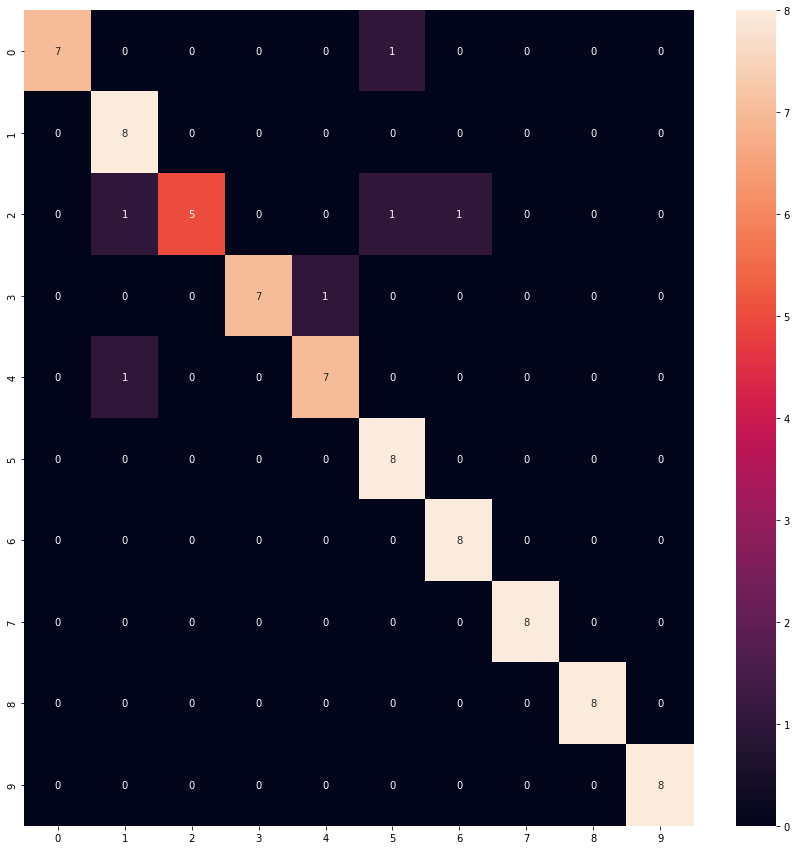

In [ ]:
cn_matrix = confusion_matrix(np.argmax(y_test,axis=1),np.argmax(y_pred,axis=1))
plt.figure(figsize = (15,15))
sns.heatmap(cn_matrix, annot=True)